### Reinforcement learning practice

<br />
<br />
November 26, 2022

Sources:

https://github.com/andriygav/MachineLearningSeminars/blob/master/sem25/

https://github.com/mswang12/minDQN

## Import libraries

In [1]:
from abc import abstractmethod

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

### RiverSwim Problem

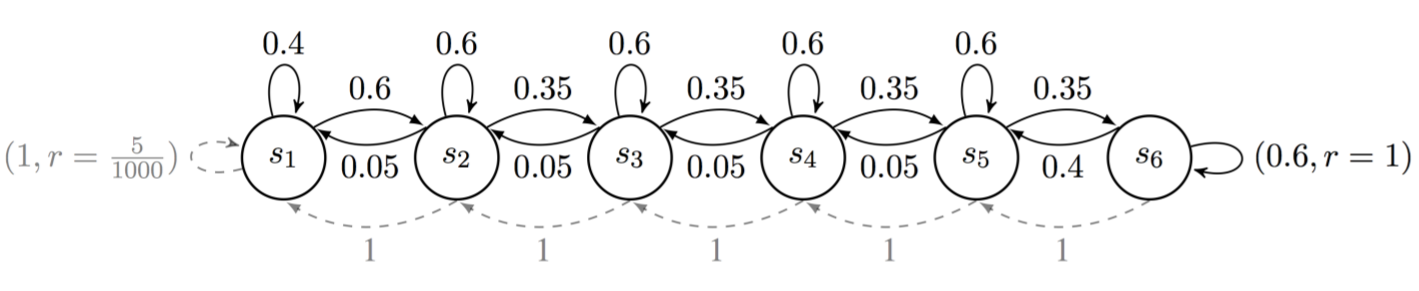

https://arxiv.org/pdf/1306.0940.pdf

Problem based on Markov processes. There are only two actions — to try to swim against the current or not to try.

In [2]:
class RiverSwim:
    def __init__(self, 
                 isc = 4, # number of states (excluding extremes)
                 ms = 16, # the maximum number of steps we take in one episode
                 lr   = 5/1000, # left reward 
                 rr   = 1.0, # right reward
                 seed = 42):
        self.rs = np.random.RandomState(seed)
        self._max_steps = ms
        self._interm_states = isc

        self._steps = 0
        self._current_state = 1

        self.lr = lr
        self.rr = rr
        
    @property
    def action_count(self):
        return 2
    
    @property
    def states_count(self):
        return 2 + self._interm_states
    
    def _get_probs(self, action):
        if action == 0:
            if self._current_state == 0:
                return [0.00, 1.00, 0.00]
            else:
                return [1.00, 0.00, 0.00]
            
        elif action == 1:
            if self._current_state == 0:
                return [0.00, 0.40, 0.60]
            if self._current_state == self.states_count - 1:
                return [0.40, 0.60, 0.00]
            else:
                return [0.05, 0.60, 0.35]

    def step(self, action):
        reward = 0.0
        if self._steps >= self._max_steps:
            return self._current_state, reward, True
        
        transition = self.rs.choice(range(3), p=self._get_probs(action))
        if transition == 0:
            self._current_state -= 1
        elif transition == 1:
            pass
        else:
            self._current_state += 1

        if self._current_state == 0:
            reward = self.lr
        elif self._current_state == self.states_count - 1:
            reward = self.rr
        
        self._steps += 1
        return self._current_state, reward, False

In [3]:
class QLearningAgent:
    def __init__(self, n, K, lr=0.2, gamma=0.95, epsilon=0.2, seed=42):
        self.rs = np.random.RandomState(seed)
        self._gamma = gamma
        self._epsilon = epsilon
        self._q_matrix = np.zeros((n, K))
        self._lr = lr

    def get_action(self, state):
        if self.rs.random() < self._epsilon:
            return self.rs.randint(0, self._q_matrix.shape[1])
        else:
            return np.argmax(self._q_matrix[state])
    
    def get_q_matrix(self):
        return self._q_matrix
        
    def start_episode(self):
        pass

    def update(self, state, action, reward, next_state):
        self._q_matrix[state, action] = self._q_matrix[state, action] + self._lr*(reward + self._gamma*np.max(self._q_matrix[next_state]) - self._q_matrix[state, action])
        return


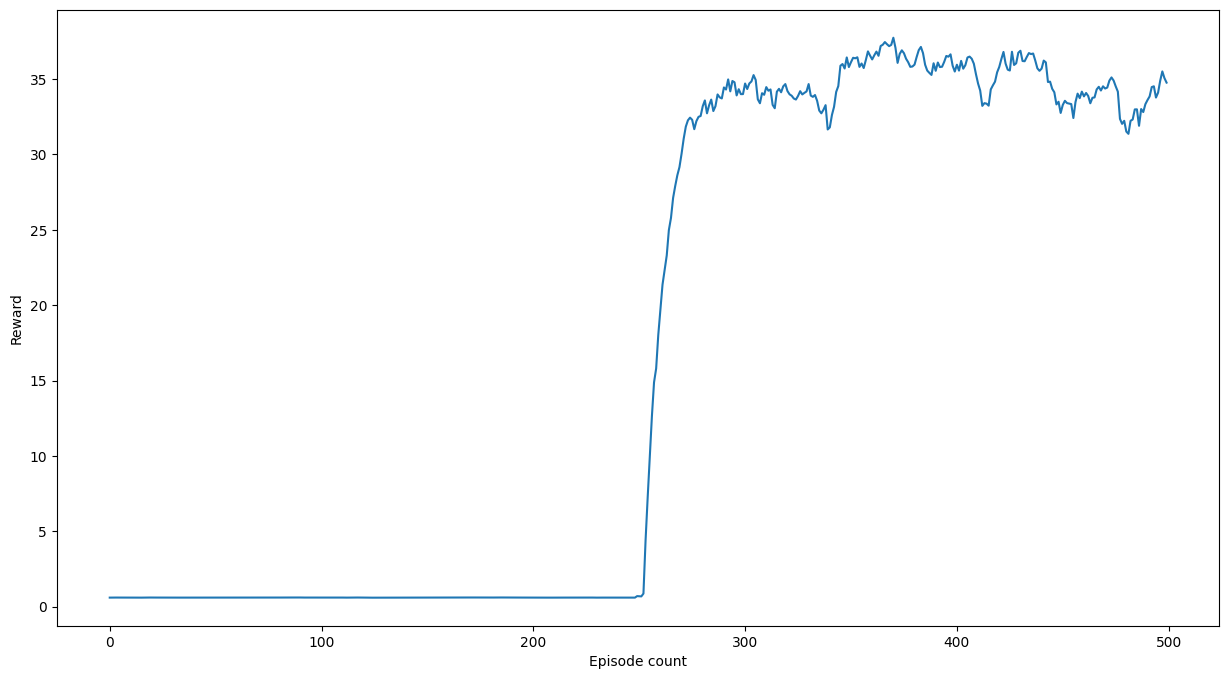

In [4]:
n = 2
ms = 128
episodes = 500
actions = 2

agent = QLearningAgent(2+n, actions)

episode_rewards = []
for ep in range(episodes):
    river_swim = RiverSwim(n, ms)

    state, ep_reward, is_done = river_swim._current_state, 0.0, False
    agent.start_episode()
    while not is_done:
        action = agent.get_action(state)
        next_state, reward, is_done = river_swim.step(action)
        agent.update(state, action, reward, next_state)
        
        state = next_state
        ep_reward += reward
        
    episode_rewards.append(ep_reward)


plt.figure(figsize=(15, 8))

plt.plot(pd.DataFrame(np.array(episode_rewards)).ewm(alpha=.1).mean())
plt.xlabel("Episode count")
plt.ylabel("Reward")
plt.show()

/tmp/ipykernel_21729/731725105.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['', 'no act', 'swim'])


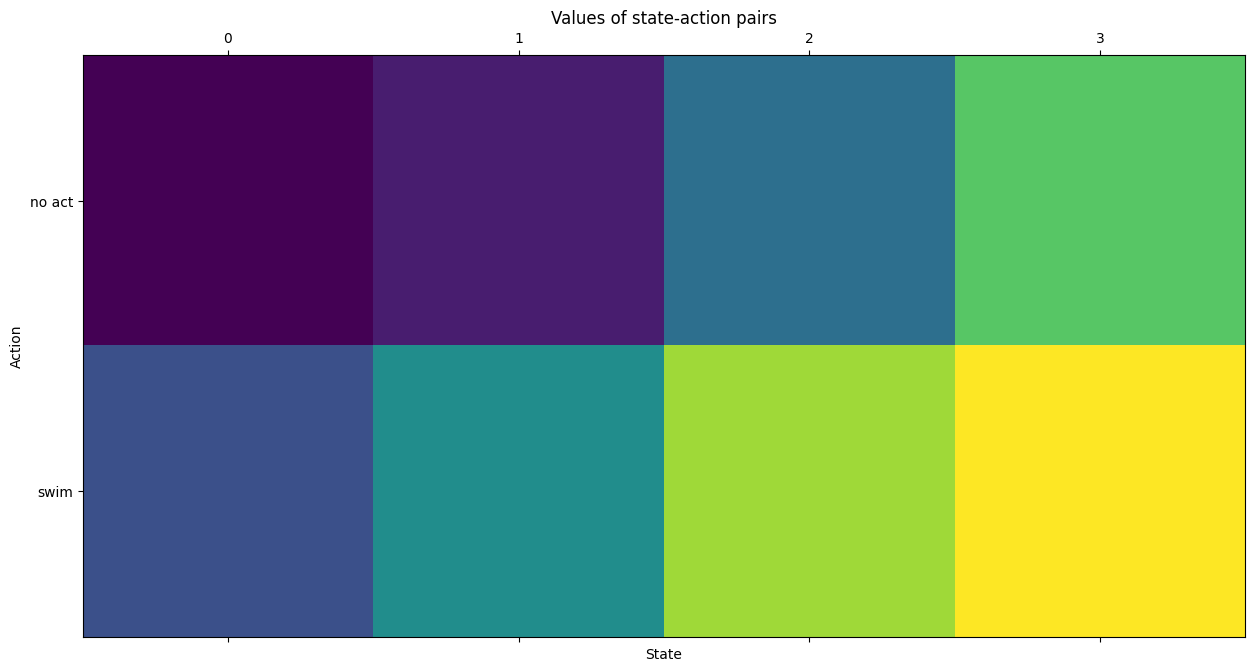

In [5]:
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111)
ax.matshow(agent.get_q_matrix().T)
ax.set_yticklabels(['', 'no act', 'swim'])
plt.xlabel("State")
plt.ylabel("Action")
plt.title("Values of state-action pairs")
plt.show()

## A Minimal Deep Q-Network

We'll be showing how to code a minimal Deep Q-Network to solve the CartPole environment.

## Step 1. Import libraries and setup the environment

In [6]:
# !pip install gym
# !pip install tensorflow

In [7]:
import gym
import tensorflow as tf
import numpy as np
from tensorflow import keras

from collections import deque
import time
import random

2022-11-24 10:03:04.312668: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-24 10:03:04.469079: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-24 10:03:04.469105: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-24 10:03:05.174418: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-

In [8]:
RANDOM_SEED = 5
tf.random.set_seed(RANDOM_SEED)

env = gym.make('CartPole-v1', render_mode='rgb_array')
np.random.seed(RANDOM_SEED)

print("Action Space: {}".format(env.action_space))
print("State space: {}".format(env.observation_space))

Action Space: Discrete(2)
State space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


In [9]:
help(env.env)

Help on OrderEnforcing in module gym.wrappers.order_enforcing object:

class OrderEnforcing(gym.core.Wrapper)
 |  OrderEnforcing(*args, **kwds)
 |  
 |  A wrapper that will produce an error if :meth:`step` is called before an initial :meth:`reset`.
 |  
 |  Example:
 |      >>> from gym.envs.classic_control import CartPoleEnv
 |      >>> env = CartPoleEnv()
 |      >>> env = OrderEnforcing(env)
 |      >>> env.step(0)
 |      ResetNeeded: Cannot call env.step() before calling env.reset()
 |      >>> env.render()
 |      ResetNeeded: Cannot call env.render() before calling env.reset()
 |      >>> env.reset()
 |      >>> env.render()
 |      >>> env.step(0)
 |  
 |  Method resolution order:
 |      OrderEnforcing
 |      gym.core.Wrapper
 |      gym.core.Env
 |      typing.Generic
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, env: gym.core.Env, disable_render_order_enforcing: bool = False)
 |      A wrapper that will produce an error if :meth:`step` is ca

### Step 2. Define the network architecture

In [10]:
# An episode a full game
train_episodes = 150

def agent(state_shape, action_shape):
    """ The agent maps X-states to Y-actions
    e.g. The neural network output is [.1, .7, .05, 0.05, .05, .05]
    The highest value 0.7 is the Q-Value.
    The index of the highest action (0.7) is action #1.
    """
    learning_rate = 0.001
    init = tf.keras.initializers.HeUniform()
    model = keras.Sequential()
    model.add(keras.layers.Dense(24, input_shape=state_shape, activation='relu', kernel_initializer=init))
    model.add(keras.layers.Dense(12, activation='relu', kernel_initializer=init))
    model.add(keras.layers.Dense(action_shape, activation='linear', kernel_initializer=init))
    model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics=['accuracy'])
    return model

def get_qs(model, state, step):
    return model.predict(state.reshape([1, state.shape[0]]))[0]


### Step 3. Define the train function using Experience Replay


In [11]:
def get_array(obs):
    return obs[0] if type(obs) is tuple else obs


def train(env, replay_memory, model, target_model, done):
    learning_rate = 0.7
    discount_factor = 0.618

    MIN_REPLAY_SIZE = 1000
    if len(replay_memory) < MIN_REPLAY_SIZE:
        return

    batch_size = 64 * 2
    # replay_memory is list of [observation, action, reward, new_observation, done])
    mini_batch = random.sample(replay_memory, batch_size)
    current_states = np.array([get_array(transition[0]) for transition in mini_batch], dtype='float32')
    current_qs_list = model.predict(current_states)
    new_current_states = np.array([get_array(transition[3]) for transition in mini_batch], dtype='float32')
    future_qs_list = target_model.predict(new_current_states)

    X = []
    Y = []
    for index, (observation, action, reward, new_observation, done) in enumerate(mini_batch):
        if not done:
            max_future_q = reward + discount_factor * np.max(future_qs_list[index])
        else:
            max_future_q = reward

        current_qs = current_qs_list[index]
        current_qs[action] = (1 - learning_rate) * current_qs[action] + learning_rate * max_future_q

        X.append(get_array(observation))
        Y.append(current_qs)
    model.fit(np.array(X, dtype='float32'), np.array(Y, dtype='float32'), batch_size=batch_size, verbose=0, shuffle=True)


### Step 4. Run the Deep Q-Network Algorithm

In [12]:
def main():
    epsilon = 1 # Epsilon-greedy algorithm in initialized at 1 meaning every step is random at the start
    max_epsilon = 1 # You can't explore more than 100% of the time
    min_epsilon = 0.01 # At a minimum, we'll always explore 1% of the time
    decay = 0.01

    # 1. Initialize the Target and Main models
    # Main Model (updated every 4 steps)
    model = agent(env.observation_space.shape, env.action_space.n)
    # Target Model (updated every 100 steps)
    target_model = agent(env.observation_space.shape, env.action_space.n)
    target_model.set_weights(model.get_weights())

    replay_memory = deque(maxlen=50_000)

    target_update_counter = 0

    # X = states, y = actions
    X = []
    y = []

    steps_to_update_target_model = 0

    for episode in range(train_episodes):
        total_training_rewards = 0
        observation = env.reset()
        done = False
        while not done:
            steps_to_update_target_model += 1
            #if True:
            #    env.render()

            random_number = np.random.rand()
            # 2. Explore using the Epsilon Greedy Exploration Strategy
            if random_number <= epsilon:
                # Explore
                action = env.action_space.sample()
            else:
                # Exploit best known action
                # model dims are (batch, env.observation_space.n)
                encoded = get_array(observation)
                encoded_reshaped = encoded.reshape([1, encoded.shape[0]])
                predicted = model.predict(encoded_reshaped).flatten()
                action = np.argmax(predicted)
            new_observation, reward, done, info, _ = env.step(action)
            replay_memory.append([observation, action, reward, new_observation, done])

            # 3. Update the Main Network using the Bellman Equation
            if steps_to_update_target_model % 4 == 0 or done:
                train(env, replay_memory, model, target_model, done)

            observation = new_observation
            total_training_rewards += reward

            if done:
                print('Total training rewards: {} after n steps = {} with final reward = {}'.format(total_training_rewards, episode, reward))
                total_training_rewards += 1

                if steps_to_update_target_model >= 100:
                    print('Copying main network weights to the target network weights')
                    target_model.set_weights(model.get_weights())
                    steps_to_update_target_model = 0
                break

        epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay * episode)
    env.close()
    return model


In [13]:
policy = main()

2022-11-24 10:03:23.001463: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-24 10:03:23.001536: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-24 10:03:23.001561: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (i107250458): /proc/driver/nvidia/version does not exist
2022-11-24 10:03:23.001875: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/avalur/.local/lib/python3.8/site-packages/keras/initializers/initia

Total training rewards: 17.0 after n steps = 0 with final reward = 1.0
Total training rewards: 22.0 after n steps = 1 with final reward = 1.0
Total training rewards: 16.0 after n steps = 2 with final reward = 1.0
Total training rewards: 29.0 after n steps = 3 with final reward = 1.0
1/1 [==============================] - 0s 80ms/step
Total training rewards: 19.0 after n steps = 4 with final reward = 1.0
Copying main network weights to the target network weights
Total training rewards: 13.0 after n steps = 5 with final reward = 1.0
1/1 [==============================] - 0s 20ms/step
Total training rewards: 19.0 after n steps = 6 with final reward = 1.0
1/1 [==============================] - 0s 22ms/step
Total training rewards: 23.0 after n steps = 7 with final reward = 1.0
1/1 [==============================] - 0s 23ms/step
Total training rewards: 13.0 after n steps = 8 with final reward = 1.0
1/1 [==============================] - 0s 19ms/step
Total training rewards: 32.0 after n steps

1/1 [==============================] - 0s 20ms/step
Total training rewards: 20.0 after n steps = 36 with final reward = 1.0
1/1 [==============================] - 0s 20ms/step
Total training rewards: 11.0 after n steps = 37 with final reward = 1.0
1/1 [==============================] - 0s 19ms/step
Total training rewards: 15.0 after n steps = 38 with final reward = 1.0
1/1 [==============================] - 0s 20ms/step
Total training rewards: 26.0 after n steps = 39 with final reward = 1.0
Copying main network weights to the target network weights
1/1 [==============================] - 0s 20ms/step
Total training rewards: 16.0 after n steps = 40 with final reward = 1.0
1/1 [==============================] - 0s 21ms/step
Total training rewards: 16.0 after n steps = 41 with final reward = 1.0
1/1 [==============================] - 0s 20ms/step
Total training rewards: 31.0 after n steps = 42 with final reward = 1.0
1/1 [==============================] - 0s 21ms/step
Total training reward

4/4 [==============================] - 0s 2ms/step
Total training rewards: 12.0 after n steps = 51 with final reward = 1.0
4/4 [==============================] - 0s 2ms/step
Total training rewards: 15.0 after n steps = 52 with final reward = 1.0
4/4 [==============================] - 0s 2ms/step
Total training rewards: 14.0 after n steps = 53 with final reward = 1.0
4/4 [==============================] - 0s 2ms/step
Total training rewards: 12.0 after n steps = 54 with final reward = 1.0
4/4 [==============================] - 0s 2ms/step
Total training rewards: 12.0 after n steps = 55 with final reward = 1.0
Copying main network weights to the target network weights
4/4 [==============================] - 0s 2ms/step
Total training rewards: 10.0 after n steps = 56 with final reward = 1.0
4/4 [==============================] - 0s 2ms/step
Total training rewards: 11.0 after n steps = 57 with final reward = 1.0
4/4 [==============================] - 0s 2ms/step
Total training rewards: 39.0 

4/4 [==============================] - 0s 2ms/step
Total training rewards: 10.0 after n steps = 60 with final reward = 1.0
4/4 [==============================] - 0s 2ms/step
Total training rewards: 17.0 after n steps = 61 with final reward = 1.0
Copying main network weights to the target network weights
4/4 [==============================] - 0s 3ms/step
Total training rewards: 11.0 after n steps = 62 with final reward = 1.0
4/4 [==============================] - 0s 2ms/step
Total training rewards: 14.0 after n steps = 63 with final reward = 1.0
4/4 [==============================] - 0s 2ms/step
Total training rewards: 11.0 after n steps = 64 with final reward = 1.0
4/4 [==============================] - 0s 2ms/step
Total training rewards: 10.0 after n steps = 65 with final reward = 1.0
4/4 [==============================] - 0s 2ms/step
Total training rewards: 14.0 after n steps = 66 with final reward = 1.0
4/4 [==============================] - 0s 2ms/step
Total training rewards: 17.0 

4/4 [==============================] - 0s 2ms/step
Total training rewards: 14.0 after n steps = 70 with final reward = 1.0
Copying main network weights to the target network weights
4/4 [==============================] - 0s 2ms/step
Total training rewards: 10.0 after n steps = 71 with final reward = 1.0
4/4 [==============================] - 0s 2ms/step
Total training rewards: 9.0 after n steps = 72 with final reward = 1.0
4/4 [==============================] - 0s 2ms/step
Total training rewards: 12.0 after n steps = 73 with final reward = 1.0
4/4 [==============================] - 0s 2ms/step
Total training rewards: 10.0 after n steps = 74 with final reward = 1.0
4/4 [==============================] - 0s 2ms/step
Total training rewards: 10.0 after n steps = 75 with final reward = 1.0
4/4 [==============================] - 0s 2ms/step
Total training rewards: 18.0 after n steps = 76 with final reward = 1.0
4/4 [==============================] - 0s 2ms/step
Total training rewards: 12.0 a

4/4 [==============================] - 0s 2ms/step
Total training rewards: 13.0 after n steps = 80 with final reward = 1.0
4/4 [==============================] - 0s 2ms/step
Total training rewards: 16.0 after n steps = 81 with final reward = 1.0
4/4 [==============================] - 0s 2ms/step
Total training rewards: 12.0 after n steps = 82 with final reward = 1.0
4/4 [==============================] - 0s 2ms/step
Total training rewards: 12.0 after n steps = 83 with final reward = 1.0
4/4 [==============================] - 0s 2ms/step
Total training rewards: 13.0 after n steps = 84 with final reward = 1.0
4/4 [==============================] - 0s 2ms/step
Total training rewards: 10.0 after n steps = 85 with final reward = 1.0
4/4 [==============================] - 0s 2ms/step
Total training rewards: 11.0 after n steps = 86 with final reward = 1.0
4/4 [==============================] - 0s 2ms/step
Total training rewards: 10.0 after n steps = 87 with final reward = 1.0
4/4 [===========

4/4 [==============================] - 0s 2ms/step
Total training rewards: 11.0 after n steps = 90 with final reward = 1.0
4/4 [==============================] - 0s 2ms/step
Total training rewards: 10.0 after n steps = 91 with final reward = 1.0
4/4 [==============================] - 0s 2ms/step
Total training rewards: 10.0 after n steps = 92 with final reward = 1.0
4/4 [==============================] - 0s 2ms/step
Total training rewards: 11.0 after n steps = 93 with final reward = 1.0
4/4 [==============================] - 0s 2ms/step
Total training rewards: 11.0 after n steps = 94 with final reward = 1.0
4/4 [==============================] - 0s 2ms/step
Total training rewards: 10.0 after n steps = 95 with final reward = 1.0
4/4 [==============================] - 0s 2ms/step
Total training rewards: 8.0 after n steps = 96 with final reward = 1.0
4/4 [==============================] - 0s 2ms/step
Total training rewards: 11.0 after n steps = 97 with final reward = 1.0
4/4 [============

4/4 [==============================] - 0s 2ms/step
Total training rewards: 11.0 after n steps = 101 with final reward = 1.0
4/4 [==============================] - 0s 2ms/step
Total training rewards: 10.0 after n steps = 102 with final reward = 1.0
4/4 [==============================] - 0s 2ms/step
Total training rewards: 10.0 after n steps = 103 with final reward = 1.0
4/4 [==============================] - 0s 2ms/step
Total training rewards: 14.0 after n steps = 104 with final reward = 1.0
4/4 [==============================] - 0s 2ms/step
Total training rewards: 11.0 after n steps = 105 with final reward = 1.0
4/4 [==============================] - 0s 2ms/step
Total training rewards: 15.0 after n steps = 106 with final reward = 1.0
4/4 [==============================] - 0s 2ms/step
Total training rewards: 10.0 after n steps = 107 with final reward = 1.0
Copying main network weights to the target network weights
4/4 [==============================] - 0s 2ms/step
Total training rewards

4/4 [==============================] - 0s 2ms/step
Total training rewards: 9.0 after n steps = 111 with final reward = 1.0
4/4 [==============================] - 0s 2ms/step
Total training rewards: 12.0 after n steps = 112 with final reward = 1.0
4/4 [==============================] - 0s 2ms/step
Total training rewards: 9.0 after n steps = 113 with final reward = 1.0
4/4 [==============================] - 0s 2ms/step
Total training rewards: 10.0 after n steps = 114 with final reward = 1.0
4/4 [==============================] - 0s 2ms/step
Total training rewards: 10.0 after n steps = 115 with final reward = 1.0
4/4 [==============================] - 0s 2ms/step
Total training rewards: 10.0 after n steps = 116 with final reward = 1.0
4/4 [==============================] - 0s 2ms/step
Total training rewards: 9.0 after n steps = 117 with final reward = 1.0
Copying main network weights to the target network weights
4/4 [==============================] - 0s 2ms/step
Total training rewards: 1

4/4 [==============================] - 0s 2ms/step
Total training rewards: 18.0 after n steps = 121 with final reward = 1.0
4/4 [==============================] - 0s 2ms/step
Total training rewards: 12.0 after n steps = 122 with final reward = 1.0
4/4 [==============================] - 0s 2ms/step
Total training rewards: 13.0 after n steps = 123 with final reward = 1.0
4/4 [==============================] - 0s 2ms/step
Total training rewards: 10.0 after n steps = 124 with final reward = 1.0
4/4 [==============================] - 0s 2ms/step
Total training rewards: 13.0 after n steps = 125 with final reward = 1.0
Copying main network weights to the target network weights
4/4 [==============================] - 0s 2ms/step
Total training rewards: 9.0 after n steps = 126 with final reward = 1.0
4/4 [==============================] - 0s 2ms/step
Total training rewards: 11.0 after n steps = 127 with final reward = 1.0
4/4 [==============================] - 0s 2ms/step
Total training rewards:

4/4 [==============================] - 0s 2ms/step
Total training rewards: 13.0 after n steps = 131 with final reward = 1.0
4/4 [==============================] - 0s 2ms/step
Total training rewards: 9.0 after n steps = 132 with final reward = 1.0
4/4 [==============================] - 0s 2ms/step
Total training rewards: 10.0 after n steps = 133 with final reward = 1.0
4/4 [==============================] - 0s 2ms/step
Total training rewards: 12.0 after n steps = 134 with final reward = 1.0
4/4 [==============================] - 0s 2ms/step
Total training rewards: 11.0 after n steps = 135 with final reward = 1.0
Copying main network weights to the target network weights
4/4 [==============================] - 0s 2ms/step
Total training rewards: 11.0 after n steps = 136 with final reward = 1.0
4/4 [==============================] - 0s 2ms/step
Total training rewards: 8.0 after n steps = 137 with final reward = 1.0
4/4 [==============================] - 0s 2ms/step
Total training rewards: 

4/4 [==============================] - 0s 2ms/step
Total training rewards: 11.0 after n steps = 141 with final reward = 1.0
4/4 [==============================] - 0s 2ms/step
Total training rewards: 12.0 after n steps = 142 with final reward = 1.0
4/4 [==============================] - 0s 2ms/step
Total training rewards: 12.0 after n steps = 143 with final reward = 1.0
4/4 [==============================] - 0s 2ms/step
Total training rewards: 11.0 after n steps = 144 with final reward = 1.0
4/4 [==============================] - 0s 2ms/step
Total training rewards: 11.0 after n steps = 145 with final reward = 1.0
Copying main network weights to the target network weights
4/4 [==============================] - 0s 2ms/step
Total training rewards: 11.0 after n steps = 146 with final reward = 1.0
4/4 [==============================] - 0s 2ms/step
Total training rewards: 11.0 after n steps = 147 with final reward = 1.0
4/4 [==============================] - 0s 2ms/step
Total training rewards

In [17]:
# !pip install gym[classic_control]

In [19]:
from IPython import display as ipythondisplay

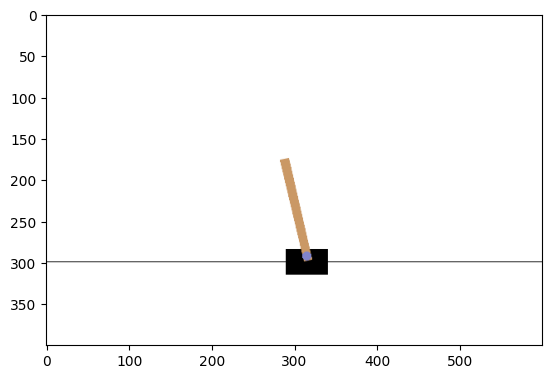

In [20]:
env.reset()
prev_screen = env.render()
plt.imshow(prev_screen)

policy_dummy = lambda *obs: 1

for _ in range(2):
    obs = env.reset()
    for _ in range(80):
        actions = policy_dummy(*obs)
        obs, reward, done, info, _ = env.step(actions) 

        screen = env.render()

        plt.imshow(screen)
        ipythondisplay.clear_output(wait=True)
        ipythondisplay.display(plt.gcf())

        if done:
            break
        
ipythondisplay.clear_output(wait=True)
env.close()

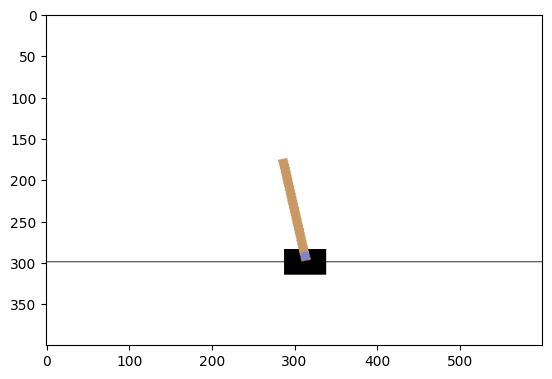

In [21]:
env.reset()
prev_screen = env.render()
plt.imshow(prev_screen)


for _ in range(1):
    obs = env.reset()
    for _ in range(80):
        encoded = get_array(obs)
        encoded_reshaped = encoded.reshape([1, encoded.shape[0]])
        predicted = policy.predict(encoded_reshaped).flatten()
        actions = np.argmax(predicted)
        obs, reward, done, info, _ = env.step(actions) 

        screen = env.render()

        plt.imshow(screen)
        ipythondisplay.clear_output(wait=True)
        ipythondisplay.display(plt.gcf())

        if done:
            break
        
ipythondisplay.clear_output(wait=True)
env.close()

In [49]:
policy.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_60 (Dense)            (None, 24)                120       
                                                                 
 dense_61 (Dense)            (None, 12)                300       
                                                                 
 dense_62 (Dense)            (None, 2)                 26        
                                                                 
Total params: 446
Trainable params: 446
Non-trainable params: 0
_________________________________________________________________
